# Kaggle competition: Shelter Animal Outcomes

https://www.kaggle.com/c/shelter-animal-outcomes/

**Дано:** данные о кошках и собаках, поступивших в приют

**Найти:** что с ними станет? Возьмут в приют / вернётся хозяин / ...

In [1]:
import numpy as np
import pandas as pd

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

грузим всё, что есть

In [3]:
train = pd.read_csv('data/shelter/train.csv')
test = pd.read_csv('data/shelter/test.csv')
sample_submission = pd.read_csv('data/shelter/sample_submission.csv')

и смотрим на это

In [4]:
train.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [5]:
test.head()

,ID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,1,Summer,2015-10-12 12:15:00,Dog,Intact Female,10 months,Labrador Retriever Mix,Red/White
1,2,Cheyenne,2014-07-26 17:59:00,Dog,Spayed Female,2 years,German Shepherd/Siberian Husky,Black/Tan
2,3,Gus,2016-01-13 12:20:00,Cat,Neutered Male,1 year,Domestic Shorthair Mix,Brown Tabby
3,4,Pongo,2013-12-28 18:12:00,Dog,Intact Male,4 months,Collie Smooth Mix,Tricolor
4,5,Skooter,2015-09-24 17:59:00,Dog,Neutered Male,2 years,Miniature Poodle Mix,White


In [6]:
sample_submission.head()

,ID,Adoption,Died,Euthanasia,Return_to_owner,Transfer
0,1,1,0,0,0,0
1,2,1,0,0,0,0
2,3,1,0,0,0,0
3,4,1,0,0,0,0
4,5,1,0,0,0,0


все фичи надо варить, причём одинаково в train и test, лучше их сразу соединим и разделим при этом флагом is_test

In [7]:
Xtrain = train.drop(['AnimalID', 'OutcomeType', 'OutcomeSubtype'], axis=1)
Xtest = test.drop(['ID'], axis=1)
Xtrain['is_test'] = False
Xtest['is_test'] = True
X = pd.concat([Xtrain, Xtest], axis=0)
X.index = range(len(X))
X.columns = X.columns.str.lower()

In [8]:
X.head()

,name,datetime,animaltype,sexuponoutcome,ageuponoutcome,breed,color,is_test
0,Hambone,2014-02-12 18:22:00,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,False
1,Emily,2013-10-13 12:44:00,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,False
2,Pearce,2015-01-31 12:28:00,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,False
3,NaN,2014-07-11 19:09:00,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,False
4,NaN,2013-11-15 12:52:00,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,False


In [9]:
X.shape

(38185, 8)

In [10]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38185 entries, 0 to 38184
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   name            27269 non-null  object
 1   datetime        38185 non-null  object
 2   animaltype      38185 non-null  object
 3   sexuponoutcome  38184 non-null  object
 4   ageuponoutcome  38161 non-null  object
 5   breed           38185 non-null  object
 6   color           38185 non-null  object
 7   is_test         38185 non-null  bool  
dtypes: bool(1), object(7)
memory usage: 2.1+ MB


Также нам необходимо закодировать значения целевой переменной

In [11]:
from sklearn.preprocessing import LabelEncoder

In [12]:
le = LabelEncoder()
y = le.fit_transform(train.OutcomeType)

# Варим фичи

будем в конце матрицы наращивать числовые фичи, не удаляя оригинальные: вдруг что всплывёт

**имя** превращаем в:
* наличие имени
* длину имени
* частоту имени

In [13]:
X['has_name'] = X.name.isnull().astype(int)

X['name_len'] = X.name.str.len()
X.name_len.fillna(X.name_len.median(), inplace=True)

X['name_words_num'] = X.name.str.split().str.len()
X.name_words_num.fillna(X.name_words_num.median(), inplace=True)

names_freq = X.name.value_counts().to_dict()
X['name_freq'] = X.name.apply(lambda x: names_freq.get(x))

Даты: переводим строки в даты

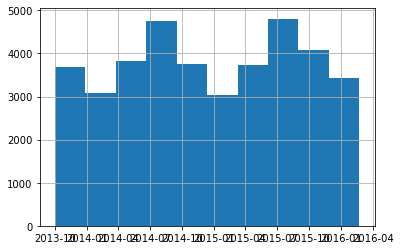

In [14]:
X.datetime = pd.to_datetime(X.datetime)
X.datetime.hist()

In [15]:
X['year'] = X.datetime.apply(lambda x: x.year)
X['month'] = X.datetime.apply(lambda x: x.month)
X['day'] = X.datetime.apply(lambda x: x.day)
X['hour'] = X.datetime.apply(lambda x: x.hour + x.minute/60)
X['weekday'] = X.datetime.apply(lambda x: x.weekday())

С типом животного тут совсем просто

In [16]:
X.animaltype.value_counts()

Dog    22251
Cat    15934
Name: animaltype, dtype: int64

In [17]:
X['is_dog'] = (X.animaltype=='Dog').astype(int)

С полом сложнее..
* Neutered, Spayed - стерилизованные
* Intact - нетронутые

In [18]:
X.sexuponoutcome.value_counts()

Neutered Male    14014
Spayed Female    12633
Intact Female     5004
Intact Male       4985
Unknown           1548
Name: sexuponoutcome, dtype: int64

In [19]:
X.sexuponoutcome.fillna('Unknown', inplace=True)

In [20]:
X['sterilization'] = X.sexuponoutcome.apply(lambda x: x.split()[0])
X.sterilization = X.sterilization.replace({'Neutered': 'Sterilized', 'Spayed': 'Sterilized'})

In [21]:
X['sex'] = X.sexuponoutcome.apply(lambda x: x.split()[-1])

In [22]:
from sklearn import preprocessing

In [23]:
le_sterilization = preprocessing.LabelEncoder()
le_sex = preprocessing.LabelEncoder()

In [24]:
X.sterilization = le_sterilization.fit_transform(X.sterilization)
X.sex = le_sex.fit_transform(X.sex)

почему мы не вставили сюда сразу числовые фичи? потому что это категориальные фичи, у них по 3 значения

In [25]:
X.ageuponoutcome.value_counts()[:30]

1 year       5737
2 years      5383
2 months     4929
3 years      2589
3 months     1788
1 month      1782
4 years      1506
5 years      1406
4 months     1283
3 weeks       950
5 months      929
6 years       927
6 months      835
8 years       772
7 years       769
2 weeks       727
10 months     653
10 years      598
8 months      569
4 weeks       465
7 months      455
9 years       394
12 years      330
9 months      313
1 weeks       247
11 months     241
1 week        220
13 years      214
11 years      174
3 days        148
Name: ageuponoutcome, dtype: int64

In [26]:
X.ageuponoutcome.str.split().str[1].value_counts()

years     15456
months    11995
year       5737
weeks      2404
month      1782
days        483
week        220
day          84
Name: ageuponoutcome, dtype: int64

In [27]:
X.ageuponoutcome.str.split().str[1].str.rstrip('s').value_counts()

year     21193
month    13777
week      2624
day        567
Name: ageuponoutcome, dtype: int64

In [28]:
t_dig = X.ageuponoutcome.str.split().str[0].fillna(0).astype(int)
t_int = X.ageuponoutcome.str.split().str[1].str.rstrip('s').replace({'year': 365, 'month': 365/12, 'week':7, 'day':1}).fillna(0)

In [29]:
X["years"] = t_dig*t_int/365

порода достаточно разнообразна и содержит в себе также некое поле "Mix" и краткошёрстность животного

In [30]:
X.breed.value_counts()[:10]

Domestic Shorthair Mix       12587
Pit Bull Mix                  2776
Chihuahua Shorthair Mix       2498
Labrador Retriever Mix        1949
Domestic Medium Hair Mix      1217
German Shepherd Mix            830
Domestic Longhair Mix          753
Siamese Mix                    562
Australian Cattle Dog Mix      513
Dachshund Mix                  437
Name: breed, dtype: int64

Сегодня сделаем просто: соединим все описания в один большой текст и посчитаем в нём вхождение каждого слова. Флаги наличия самых популярных и включим как фичи

In [31]:
from collections import Counter

In [32]:
one_big_text = " ".join(X.breed)
words = one_big_text.replace('/',' / ').split()
most_common = Counter(words).most_common()
most_common[:20]

[('Mix', 31871),
 ('Shorthair', 16290),
 ('Domestic', 14877),
 ('/', 4371),
 ('Chihuahua', 3690),
 ('Retriever', 3539),
 ('Bull', 3529),
 ('Pit', 3458),
 ('Labrador', 3280),
 ('Terrier', 2435),
 ('Shepherd', 2001),
 ('Australian', 1516),
 ('German', 1427),
 ('Hair', 1321),
 ('Medium', 1287),
 ('Longhair', 1128),
 ('Miniature', 1126),
 ('Dachshund', 1116),
 ('Dog', 996),
 ('Cattle', 905)]

Можно было бы просто вставить флаги вхождения первых, скажем, 4 слов. Но давайте посмотрим, а насколько они важны? Составим матрицу, состоящую только из вхождения первых N слов, обучим на них дерево и проверим важность фичей

In [33]:
Xbreed = pd.DataFrame()
for col, num in most_common[:10]:
    Xbreed[col] = X[~X.is_test].breed.str.contains(col).astype(int)

In [34]:
from sklearn.tree import DecisionTreeClassifier

In [35]:
clf = DecisionTreeClassifier(max_depth=4)

In [36]:
clf.fit(Xbreed, train.OutcomeType)

DecisionTreeClassifier(max_depth=4)

In [37]:
clf.feature_importances_

array([0.03160924, 0.02125524, 0.82691139, 0.0446535 , 0.        ,
       0.        , 0.0701799 , 0.00539074, 0.        , 0.        ])

In [38]:
Xbreed.columns

Index(['Mix', 'Shorthair', 'Domestic', '/', 'Chihuahua', 'Retriever', 'Bull',
       'Pit', 'Labrador', 'Terrier'],
      dtype='object')

В принципе, оказалось, что влияет по большей части только **Domestic**. Но включим сюда на всякий случай ещё один признак

In [39]:
X['is_domestic'] = X.breed.str.contains('Domestic').astype(int)
X['is_mix'] = X.breed.str.contains('Mix').astype(int)

последнее! цвет. Выглядит похоже на проблему породы, повторим те же операции

In [40]:
X.color.value_counts()[:10]

Black/White          4043
Black                3265
Brown Tabby          2359
Brown Tabby/White    1333
White                1333
Brown/White          1257
Orange Tabby         1187
Tan/White            1114
Tricolor             1067
Blue/White           1004
Name: color, dtype: int64

In [41]:
one_big_text = " ".join(X.color)
words = one_big_text.replace('/',' / ').split()
most_common = Counter(words).most_common()
most_common[:20]

[('/', 19862),
 ('White', 17362),
 ('Black', 11567),
 ('Brown', 9550),
 ('Tabby', 7405),
 ('Tan', 4374),
 ('Blue', 3391),
 ('Orange', 2015),
 ('Brindle', 1489),
 ('Red', 1397),
 ('Tricolor', 1285),
 ('Cream', 917),
 ('Tortie', 878),
 ('Point', 852),
 ('Calico', 802),
 ('Chocolate', 741),
 ('Torbie', 567),
 ('Gray', 554),
 ('Sable', 459),
 ('Merle', 458)]

In [42]:
Xcolor = pd.DataFrame()
for col, num in most_common[:10]:
    Xcolor[col] = X[~X.is_test].color.str.contains(col).astype(int)

In [43]:
clf.fit(Xcolor, train.OutcomeType)

DecisionTreeClassifier(max_depth=4)

In [44]:
clf.feature_importances_

array([0.13222148, 0.09588076, 0.0702783 , 0.06136179, 0.63291544,
       0.00164846, 0.        , 0.        , 0.00569378, 0.        ])

In [45]:
Xcolor.columns

Index(['/', 'White', 'Black', 'Brown', 'Tabby', 'Tan', 'Blue', 'Orange',
       'Brindle', 'Red'],
      dtype='object')

Здесь важность менее сосредоточена, возьмём первые 5 фичей. Самая важная, Tabby - это полосатость

In [46]:
X['is_color_tabby'] = X.color.str.contains('Tabby').astype(int)
X['is_color_mix'] = X.color.str.contains('/').astype(int)
X['is_color_white'] = X.color.str.contains('White').astype(int)
X['is_color_black'] = X.color.str.contains('Black').astype(int)
X['is_color_brown'] = X.color.str.contains('Brown').astype(int)

Осталось проверить итоговую таблицу на пропуски

In [47]:
X.isnull().sum()

name              10916
datetime              0
animaltype            0
sexuponoutcome        0
ageuponoutcome       24
breed                 0
color                 0
is_test               0
has_name              0
name_len              0
name_words_num        0
name_freq         10916
year                  0
month                 0
day                   0
hour                  0
weekday               0
is_dog                0
sterilization         0
sex                   0
years                 0
is_domestic           0
is_mix                0
is_color_tabby        0
is_color_mix          0
is_color_white        0
is_color_black        0
is_color_brown        0
dtype: int64

In [48]:
X.name_freq.fillna(X.name_freq.median(), inplace=True)

Разделим обратно на обучающую и тестовую выборки, дропнув при этом все лишние столбцы, которые были изначально

In [49]:
Xtrain_prep = X[~X.is_test].drop(Xtrain.columns.str.lower(), axis=1)
Xtest_prep = X[X.is_test].drop(Xtrain.columns.str.lower(), axis=1)

In [50]:
Xtrain_prep.shape

(26729, 20)

-----

# Всё

Всё, у нас есть Xtrain, Xtest, ytrain. Осталось получить ytrain.

Обучим решающее дерево, причём применим кросс-валидацию для подбора гиперпараметра глубины дерева

Обращаю внимание, что мы в явном виде указали вид функционала качества: scoring='neg_log_loss'. Выбрана именно эта функция, так как именно она будет оценивать качество на Kaggle

In [51]:
from sklearn.model_selection import GridSearchCV

In [52]:
depths = np.arange(1,10)
#features_num = np.arange(5,15)
grid = {'max_depth': depths}#, 'max_features': features_num}
gridsearch = GridSearchCV(DecisionTreeClassifier(), grid, scoring='neg_log_loss', cv=5)

In [53]:
%%time
gridsearch.fit(Xtrain_prep, y)

Wall time: 3.65 s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
             scoring='neg_log_loss')

In [54]:
sorted(gridsearch.grid_scores_, key = lambda x: -x.mean_validation_score)

AttributeError: 'GridSearchCV' object has no attribute 'grid_scores_'

In [ ]:
scores = [-x.mean_validation_score for x in gridsearch.grid_scores_]
plt.plot(depths, scores)
plt.scatter(depths, scores)
best_point = np.argmin(scores)
plt.scatter(depths[best_point], scores[best_point], c='g', s=100)

Так, отлично, спасли себя от переобучения (правда, в Grid можно было указать и другие параметры и найти более оптимальную точку).

Фиксируем max_depth=5

In [ ]:
clf_final = DecisionTreeClassifier(max_depth=5)

In [ ]:
clf_final.fit(Xtrain_prep, y)

Делаем предсказания

In [ ]:
y_pred_proba = clf_final.predict_proba(Xtest_prep)
y_pred = clf_final.predict(Xtest_prep)

Формируем сабмит

In [ ]:
submit = pd.DataFrame(y_pred_proba, columns=sample_submission.columns[1:])
submit['ID'] = sample_submission.ID
submit = submit[[submit.columns[-1]]+list(submit.columns[:-1])]
submit.to_csv('data/shelter/res/submit.csv', index=False)

### Что оказалось под капотом?

In [ ]:
from sklearn.tree import export_graphviz

def get_tree_dot_view(clf, feature_names=None, class_names=None):
    print(export_graphviz(clf, out_file=None, filled=True, feature_names=feature_names, class_names=class_names))

http://www.webgraphviz.com

In [ ]:
pd.Series(le.inverse_transform(y)).value_counts().sort_index()

In [ ]:
get_tree_dot_view(clf_final, list(Xtrain_prep.columns), list(le.classes_))

Сохраним для следующего ноутбука

In [ ]:
Xtrain_prep.to_pickle('data/shelter/res/xtrain.pkl')
Xtest_prep.to_pickle('data/shelter/res/xtest.pkl')

Также [можно](http://scikit-learn.org/stable/modules/model_persistence.html) сохранять и модели:


In [ ]:
from sklearn.externals import joblib

In [ ]:
joblib.dump(clf, 'data/shelter/res/clf_decisiontree_maxdepth5.pkl')